  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=c7a7df2d27f67d26465e9921e3a250aa525b3d9a85f54a1890854adb8398b623
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm
Mounted at /content/drive
Class 0: 166 images after balancing
Class 1: 166 images after balancing
Class 2: 166 images after balancing
Class 3: 166 images after balancing
Class 4: 166 images after balancing
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Accuracy on test set after PSO feature extraction and SVM training: 0.5180722891566265


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


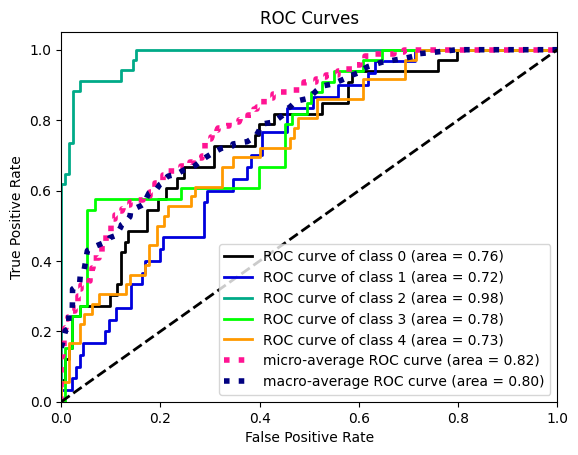

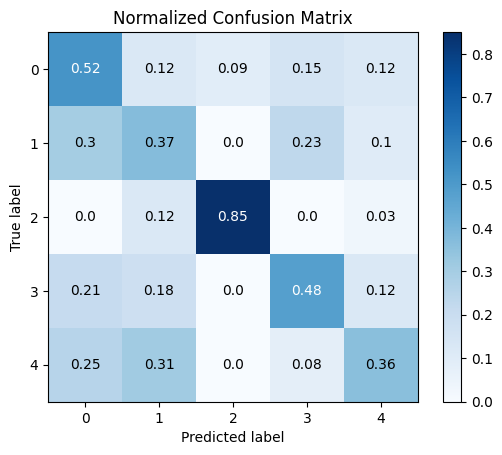

['/content/drive/MyDrive/Colab Notebooks/tabeeb.pkl']

In [ ]:
# Install the required packages
!pip install pyswarm scikit-learn imbalanced-learn scikit-plot

# Import necessary libraries
import numpy as np
import cv2
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from pyswarm import pso
from imblearn.over_sampling import RandomOverSampler
import scikitplot as skplt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  # Import matplotlib for plotting
import joblib  # Import joblib for model saving

# Mount Google Drive to access files
drive.mount('/content/drive')

# Define the path to the dataset folder
dataset_folder_path = '/content/drive/MyDrive/Colab Notebooks/Kaggle_API_Credentials/gaussian_filtered_images/gaussian_filtered_images'

# Initialize lists to store images and their corresponding labels
X = []  # Images
y = []  # Labels

# List all class folders in the dataset directory and sort them
class_folders = sorted(os.listdir(dataset_folder_path))

# Calculate the number of images per class in the subset
subset_size = 1000
images_per_class = subset_size // len(class_folders)

# Loop through each class folder
for class_label, class_folder in enumerate(class_folders):
    class_path = os.path.join(dataset_folder_path, class_folder)
    # Check if the path is a directory
    if os.path.isdir(class_path):
        # Initialize counter for images in the class
        images_count = 0
        # Loop through each image file in the class folder
        for image_file in os.listdir(class_path):
            # Check if the number of images processed for the class reaches the required number
            if images_count >= images_per_class:
                break
            image_path = os.path.join(class_path, image_file)
            # Check if the file is an image
            if image_path.endswith(('.jpg', '.jpeg', '.png')):
                # Read the image using OpenCV
                image = cv2.imread(image_path)
                # Resize the image to 128x128 pixels
                image = cv2.resize(image, (128, 128))
                # Append the resized image to the list of images
                X.append(image)
                # Append the class label to the list of labels
                y.append(class_label)
                # Increment the counter
                images_count += 1

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Check if there are any images in the dataset
if len(X) == 0:
    raise ValueError("No images found in the dataset.")

# Balance the dataset using RandomOverSampler to handle class imbalance
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X.reshape(len(X), -1), y)

# Check if resampling resulted in any images
if len(X_resampled) == 0:
    raise ValueError("No resampled images available.")

# Print the number of images in each class after balancing
class_counts_balanced = np.bincount(y_resampled)
for class_label, count in enumerate(class_counts_balanced):
    print(f"Class {class_label}: {count} images after balancing")

# PSO parameters
num_particles = 5
num_iterations = 10
num_features = X_resampled.shape[1]

# Initialize particles' positions randomly
particles_position = np.random.rand(num_particles, num_features)
global_best_position = None
global_best_accuracy = -1.0

j=1
# PSO optimization loop
for _ in range(num_iterations):
    for particle_index in range(num_particles):
        current_particle = particles_position[particle_index]

        # Select features based on the current particle's position
        selected_features = current_particle > 0.5
        selected_indices = [i for i, feat in enumerate(selected_features) if feat]
        X_selected = X_resampled[:, selected_indices]

        # Split the data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.2, random_state=42)

        # Train an SVM model using the selected features
        svm = SVC(kernel='linear', probability=True)
        svm.fit(X_train, y_train)

        # Calculate accuracy on the test set
        acc = svm.score(X_test, y_test)
        print(j)
        j=j+1

        # Update global best accuracy and position if needed
        if acc > global_best_accuracy:
            global_best_accuracy = acc
            global_best_position = current_particle.copy()

    # Update particles' positions based on the global best position
    particles_position = global_best_position + np.random.rand(num_particles, num_features)

# Select features based on the global best position obtained from PSO
selected_features = global_best_position > 0.5
selected_indices = [i for i, feat in enumerate(selected_features) if feat]
X_selected_final = X_resampled[:, selected_indices]

# Split the data into train and test sets using the selected features
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_selected_final, y_resampled, test_size=0.2, random_state=42)

# Train an SVM model using the selected features
svm_final = SVC(kernel='linear', probability=True)
svm_final.fit(X_train_final, y_train_final)

# Evaluate the final model's accuracy on the test set
final_accuracy = svm_final.score(X_test_final, y_test_final)
print("Accuracy on test set after PSO feature extraction and SVM training:", final_accuracy)

# Plot ROC curve
skplt.metrics.plot_roc_curve(y_test_final, svm_final.predict_proba(X_test_final))
plt.show()

# Plot confusion matrix
y_pred = svm_final.predict(X_test_final)
cm = confusion_matrix(y_test_final, y_pred)
skplt.metrics.plot_confusion_matrix(y_test_final, y_pred, normalize=True)
plt.show()

# Save the trained SVM model
joblib.dump(svm_final,'/content/drive/MyDrive/Colab Notebooks/tabeeb.pkl')